# References

In [17]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.sys.path.append('../fastai/') #fastai version 1

from pathlib import Path
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from fastai import *
from fastai.vision import *
from fastai.vision.image import *

# Global Variables

In [18]:
torch.cuda.set_device(1)
torch.backends.cudnn.benchmark=True

DP = Path('/home/Deep_Learner/work/datasets/human-protein-atlas-image-classification/')
STAGE_ONE_DATA = DP/'stage1_data'
TRAIN_PNGS = 'train_pngs'
TRAIN_LABELS = 'labels.csv'
TEST_PNGS = 'test_pngs'
TRAIN_CSV = 'train.csv'
SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'


SUBMISSIONS = DP/STAGE_ONE_DATA/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)


filter_colors = ['blue', 'green', 'red', 'yellow']

IdToCatDict = {0:'Nucleoplasm',
               1:'Nuclear_membrane',
               2:'Nucleoli',
               3:'Nucleoli_fibrillar_center',
               4:'Nuclear_speckles',
               5:'Nuclear_bodies',
               6:'Endoplasmic_reticulum',
               7:'Golgi_apparatus',
               8:'Peroxisomes',
               9:'Endosomes',
               10:'Lysosomes',
               11:'Intermediate_filaments',
               12:'Actin_filaments',
               13:'Focal_adhesion_sites',
               14:'Microtubules',
               15:'Microtubule_ends',
               16:'Cytokinetic_bridge',
               17:'Mitotic_spindle',
               18:'Microtubule_organizing_center',
               19:'Centrosome',
               20:'Lipid_droplets',
               21:'Plasma_membrane',
               22:'Cell_junctions',
               23:'Mitochondria',
               24:'Aggresome',
               25:'Cytosol',
               26:'Cytoplasmic_bodies',
               27:'Rods_&_rings'}

sz = 512
bs = 64
val_split = 0.2
np.random.seed(42)

# Data

In [19]:
def open_4_channel(fname):
    fname = str(fname)
    # strip extension before adding color
    if fname.endswith('.png'):
        fname = fname[:-4]
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(fname+'_'+color+'.png', flags).astype(np.float32)/255
           for color in colors]
    
    x = np.stack(img, axis=-1)
    return Image(pil2tensor(x, np.float32).float())


class ImageMulti4Channel(ImageMultiDataset):
    def __init__(self, fns, labels, classes=None, **kwargs):
        super().__init__(fns, labels, classes, **kwargs)
        self.image_opener = open_4_channel

In [20]:
df = pd.read_csv(STAGE_ONE_DATA/TRAIN_CSV)
fns = pd.Series([id + '.png' for id in df.Id])
labels = [targ.split(' ') for targ in df.Target]
trn_ds, val_ds = ImageMulti4Channel.from_folder(path=STAGE_ONE_DATA,
                                                folder=TRAIN_PNGS, 
                                                fns=fns, 
                                                labels=labels,
                                                valid_pct = val_split,
                                                classes=[str(i) for i in range(28)])

../fastai/fastai/vision/data.py:122: UserWarning: `ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.
  warnings.warn("`ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.")


In [21]:
#df_test = pd.read_csv(STAGE_ONE_DATA/SAMPLE_SUBMISSION_CSV)
#fns_test = pd.Series([id + '.png' for id in df_test.Id])
#labels_test = [str(targ).split(' ') for targ in df_test.Predicted]
#test_ds,_ = ImageMulti4Channel.from_folder(
#    path = STAGE_ONE_DATA, 
#    folder=TEST_PNGS, 
#    fns=fns_test, 
#    labels=labels_test,
#    valid_pct=0,
#    classes=['0']
#)

In [22]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(STAGE_ONE_DATA/TEST_PNGS)}))
test_ds,_ = ImageMulti4Channel.from_folder(
    path = STAGE_ONE_DATA, 
    folder = TEST_PNGS, 
    fns = pd.Series(test_ids), 
    labels = [['0'] for _ in range(len(test_ids))],
    valid_pct=0,
    classes=['0'],
)

../fastai/fastai/vision/data.py:122: UserWarning: `ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.
  warnings.warn("`ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.")


In [23]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.05, max_warp=0.)

In [24]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [25]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=STAGE_ONE_DATA, bs=bs, ds_tfms=(trn_tfms, []), num_workers=8, size=sz).normalize(protein_stats)

# Model

In [26]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}


class Resnet4Channel(nn.Module):
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()

        self.encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        
        # we initialize this conv to take in 4 channels instead of 3
        # we keeping corresponding weights and initializing new weights with zeros
        # this trick taken from https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
        w = self.encoder.conv1.weight
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        
        self.bn1 = self.encoder.bn1
        self.relu = nn.ReLU(inplace=True) 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.encoder.layer1
        self.layer2 = self.encoder.layer2
        self.layer3 = self.encoder.layer3
        self.layer4 = self.encoder.layer4
        
        self.avgpool = self.encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth==34 else 4), num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Loss Function

In [27]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

# Train

In [28]:
resnet50 = Resnet4Channel(encoder_depth=50)

In [29]:
f1_score = partial(fbeta, thresh=0.5, beta=1)

In [30]:
learn = ClassificationLearner(
    data=data,
    model=resnet50,
    loss_func=F.binary_cross_entropy_with_logits,
    #loss_func=FocalLoss(),
    path=STAGE_ONE_DATA,    
    metrics=[f1_score]
)

In [31]:
learn.unfreeze()

In [32]:
learn.lr_find()

RuntimeError: CUDA error: out of memory

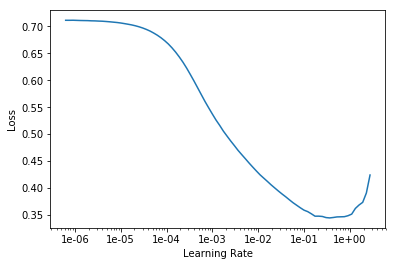

In [31]:
learn.recorder.plot()

In [32]:
lr = 0.01

In [33]:
learn.fit_one_cycle(20, slice(lr))

Total time: 53:05
epoch  train_loss  valid_loss  fbeta   
1      0.130200    0.146852    0.388930  (02:41)
2      0.121962    0.148459    0.442670  (02:40)
3      0.120659    0.125784    0.452106  (02:40)
4      0.118589    0.129387    0.428716  (02:39)
5      0.115391    0.163984    0.447932  (02:39)
6      0.114821    0.138222    0.491987  (02:39)
7      0.109604    0.136291    0.525457  (02:39)
8      0.107522    0.119311    0.522222  (02:39)
9      0.101589    0.131579    0.490353  (02:37)
10     0.100474    0.108896    0.571583  (02:39)
11     0.097399    0.108986    0.582967  (02:38)
12     0.093851    0.106814    0.615101  (02:38)
13     0.089337    0.102818    0.620778  (02:38)
14     0.088372    0.096513    0.616014  (02:38)
15     0.084325    0.089300    0.680281  (02:39)
16     0.080916    0.086166    0.680590  (02:38)
17     0.078836    0.082739    0.689119  (02:38)
18     0.077355    0.080840    0.695626  (02:39)
19     0.076507    0.079993    0.702401  (02:39)
20     0.07

In [38]:
learn.save('resnet50_basic')

# Predictions

In [34]:
preds,_ = learn.get_preds(DatasetType.Test)

/home/william/anaconda3/envs/fastaiv1/lib/python3.7/site-packages/torch/nn/functional.py:1124: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [37]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.5)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'protein_predictions.csv', header=True, index=False)